# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import glob

from collections import Counter
from wordcloud import WordCloud,STOPWORDS

import tensorflow as tf
import keras
from keras.preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from tqdm import tqdm
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu

from gtts import gTTS

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.core.debugger import set_trace
from IPython import display

pd.set_option('display.max_colwidth',-1) # Set the max column width to see the complete caption

/tmp/ipykernel_20410/3875940065.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1) # Set the max column width to see the complete caption


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [3]:
#Import the dataset and read the image into a seperate variable

images='../data/Flickr8K/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [4]:
# all_imgs[:5]

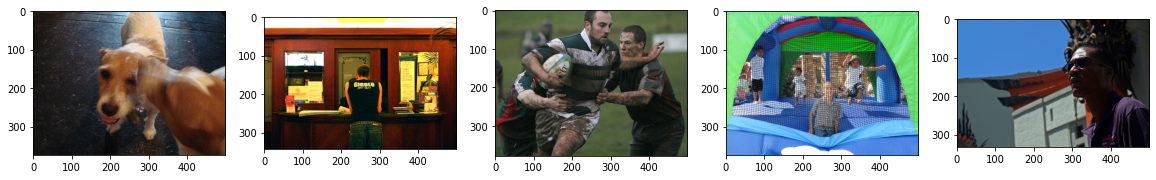

In [5]:
#Visualise both the images & text present in the dataset

figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, all_imgs[0:5]):
    img = Image.open(image)
    ax.imshow(img)

In [6]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    with open(filename, 'r', encoding="latin-1") as f:
        text = f.readlines() 
    return text

doc = load_doc('../data/Flickr8K/captions.txt')
doc[:5]

['image,caption\n',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n']

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
all_img_id = [x.split(',')[0] for x in doc[1:]] #store all the image id here
all_img_vector = ['../data/Flickr8K/Images/' + img for img in all_img_id] #store all the image path here
annotations = [x.split(',')[1] for x in doc[1:]] #store all the captions here

df_data = pd.DataFrame(list(zip(all_img_id, all_img_vector, annotations)), columns=['ID', 'Path', 'Captions']) 

df_data.shape
df_data.head(10)

(40455, 3)

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,../data/Flickr8K/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n
1,1000268201_693b08cb0e.jpg,../data/Flickr8K/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n
2,1000268201_693b08cb0e.jpg,../data/Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n
3,1000268201_693b08cb0e.jpg,../data/Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n
4,1000268201_693b08cb0e.jpg,../data/Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n
5,1001773457_577c3a7d70.jpg,../data/Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n
6,1001773457_577c3a7d70.jpg,../data/Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n
7,1001773457_577c3a7d70.jpg,../data/Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n
8,1001773457_577c3a7d70.jpg,../data/Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n
9,1001773457_577c3a7d70.jpg,../data/Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n


In [8]:
#Create a list which contains all the captions
annotations = [x.split(',')[1] for x in doc[1:]]

#add the <start> & <end> token to all those captions as well
annotations = ['<start>' + ' ' +  line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path = all_img_vector

# annotations = annotations[:5000]
# all_img_path = all_img_path[:5000]

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [9]:
annotations[:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way .\n <end>',
 '<start> A girl going into a wooden building .\n <end>',
 '<start> A little girl climbing into a wooden playhouse .\n <end>',
 '<start> A little girl climbing the stairs to her playhouse .\n <end>',
 '<start> A little girl in a pink dress going into a wooden cabin .\n <end>']

In [10]:
def clean_punctuation(text):
    for punct in string.punctuation:
        text = text.replace(punct, " ")
    return text

In [11]:
#Create the vocabulary & the counter for the captions

vocabulary = [word.lower() for line in annotations for word in line.split()]
vocabulary = [word for word in vocabulary if word not in STOPWORDS]
vocabulary = [word.strip() for word in vocabulary if word not in ['<start>', '<end>']]
vocabulary = [word.strip() for word in vocabulary if word not in string.punctuation]
val_count = Counter(vocabulary)
# val_count

In [12]:
#Visualise the top 30 occuring words in the captions
sorted(val_count.items(), key=lambda item: item[1], reverse=True)[:30]

[('dog', 7948),
 ('man', 7137),
 ('two', 5132),
 ('white', 3706),
 ('black', 3620),
 ('boy', 3514),
 ('woman', 3304),
 ('girl', 3277),
 ('wearing', 2916),
 ('people', 2811),
 ('water', 2676),
 ('young', 2587),
 ('red', 2553),
 ('brown', 2457),
 ('blue', 2125),
 ('dogs', 2095),
 ('running', 1996),
 ('playing', 1954),
 ('little', 1736),
 ('shirt', 1735),
 ('standing', 1702),
 ('ball', 1678),
 ('grass', 1565),
 ('person', 1515),
 ('child', 1507),
 ('snow', 1439),
 ('jumping', 1430),
 ('front', 1322),
 ('sitting', 1322),
 ('small', 1257)]

<Figure size 576x576 with 0 Axes>

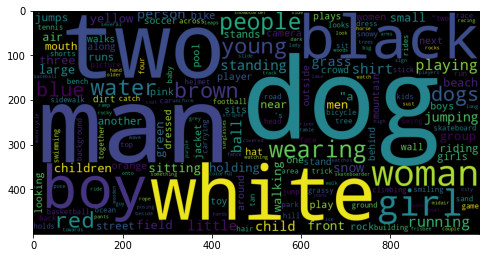

In [13]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(val_count)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [14]:
delimiter_filters = [x for x in string.punctuation if x not in ['<', '>']] + [' ', '\n']

In [15]:
# create the tokenizer
vocab_size = 5001
tokenizer = Tokenizer(num_words=vocab_size,
                     filters=delimiter_filters,
                     lower=True, 
                     char_level=False,
                     oov_token="UNK")

# update vocab
tokenizer.fit_on_texts(annotations)

# convert to sequence of integers for training
train_seqs = tokenizer.texts_to_sequences(annotations)

# padding token
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [16]:
tokenizer.word_index['<start>']
tokenizer.word_index['<end>']

3

4

In [17]:
train_seqs[:5]

[[3, 2, 44, 5, 2, 89, 173, 8, 116, 52, 2, 389, 13, 385, 5, 29, 1, 670, 4],
 [3, 2, 20, 313, 64, 2, 197, 120, 4],
 [3, 2, 39, 20, 116, 64, 2, 197, 2368, 4],
 [3, 2, 39, 20, 116, 6, 385, 21, 63, 2368, 4],
 [3, 2, 39, 20, 5, 2, 89, 173, 313, 64, 2, 197, 2887, 4]]

In [18]:
# Create word-to-index and index-to-word mappings.
# tokenizer.word_index
# tokenizer.index_word

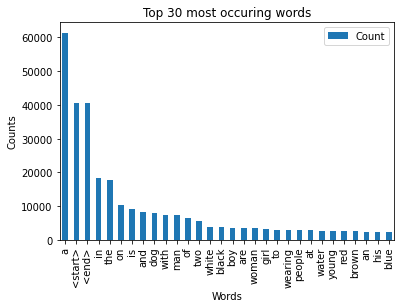

In [19]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
most_common_words = sorted(tokenizer.word_counts.items(), key=lambda item: item[1], reverse=True)[:30]
df_most_common_words = pd.DataFrame(most_common_words, columns = ['Word', 'Count'])
df_most_common_words.plot.bar(x='Word',y='Count');
plt.title("Top 30 most occuring words");
plt.xlabel("Words");
plt.ylabel("Counts");

In [20]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

train_seqs_len = [len(seq) for seq in train_seqs]
max_seq_len = max(train_seqs_len)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', 
                                                          maxlen=max_seq_len,
                                                          dtype='int32', value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 35)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [21]:
IMAGE_SHAPE = (299, 299)

In [22]:
#create the dataset consisting of image paths
image_dataset = tf.data.Dataset.from_tensor_slices(df_data['Path'].unique())

2022-06-11 18:21:55.613947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 18:21:55.624235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 18:21:55.624639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 18:21:55.625412: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [23]:
[i for i in image_dataset][:5]

[<tf.Tensor: shape=(), dtype=string, numpy=b'../data/Flickr8K/Images/1000268201_693b08cb0e.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'../data/Flickr8K/Images/1001773457_577c3a7d70.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'../data/Flickr8K/Images/1002674143_1b742ab4b8.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'../data/Flickr8K/Images/1003163366_44323f5815.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'../data/Flickr8K/Images/1007129816_e794419615.jpg'>]

In [24]:
def load_and_preprocess_image(image_path):
    #pre-processing steps
    img = tf.io.read_file(image_path, name=None)
    img = tf.image.decode_jpeg(img, channels=0) 
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img, data_format=None)
    return img, image_path

In [25]:
[i for i in tf.data.Dataset.from_tensor_slices(df_data['Path'][:1]).map(load_and_preprocess_image)]

[(<tf.Tensor: shape=(299, 299, 3), dtype=float32, numpy=
  array([[[-5.4579198e-01, -5.1085913e-01, -3.7435186e-01],
          [-1.4921635e-01, -1.9675493e-04, -3.1106710e-02],
          [-9.7177267e-02,  4.6858430e-02,  4.3021560e-02],
          ...,
          [-9.7224247e-01, -9.6819955e-01, -9.8191810e-01],
          [-9.6078575e-01, -9.4020623e-01, -9.7377020e-01],
          [-9.6212077e-01, -9.3846858e-01, -9.8195148e-01]],
  
         [[-5.7653260e-01, -5.3617233e-01, -4.2858374e-01],
          [-1.4806336e-01,  5.8089495e-03, -5.5708170e-02],
          [-7.8158259e-02,  6.0893416e-02,  7.8846335e-02],
          ...,
          [-9.6420521e-01, -9.5636207e-01, -9.8523390e-01],
          [-9.3927324e-01, -9.2645574e-01, -9.5595336e-01],
          [-9.9189347e-01, -9.6899247e-01, -9.7989315e-01]],
  
         [[-5.9273523e-01, -5.6866682e-01, -4.3528360e-01],
          [-1.3315433e-01,  5.4714680e-03, -1.3691187e-02],
          [-8.0161095e-02,  5.6944609e-02,  1.0495746e-01],
     

In [26]:
#applying the function to the image path dataset, such that the transformed dataset should contain images & their path
image_dataset = image_dataset.map(load_and_preprocess_image)

In [27]:
image_dataset

<MapDataset element_spec=(TensorSpec(shape=(299, 299, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [28]:
#batch dataset
image_dataset = image_dataset.batch(8, drop_remainder=False)

In [29]:
image_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [30]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = image_model.input # get the input of the image_model
hidden_layer = image_model.layers[-1].output # get the output of the image_model

image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [31]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
reshape_size = (-1, 8*8, 2048)
image_features_dict = {}
for image_batch, image_path_batch in tqdm(image_dataset):
    img_features = image_features_extract_model(image_batch)
    img_features = tf.reshape(img_features, reshape_size)
    for img_feature, image_path in zip(img_features, image_path_batch):
        image_path = image_path.numpy().decode("utf-8")
        image_features_dict[image_path] = img_feature.numpy()

100%|███████████████████████████████████████| 1012/1012 [01:48<00:00,  9.29it/s]


In [32]:
image_features_dict['../data/Flickr8K/Images/1000268201_693b08cb0e.jpg']

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.16994609],
       [0.        , 0.        , 1.0105467 , ..., 0.        , 0.        ,
        0.0611993 ],
       ...,
       [0.        , 0.        , 2.038265  , ..., 1.2027566 , 0.        ,
        1.9926809 ],
       [0.        , 0.        , 0.90492946, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.252852  , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [33]:
img_feature.shape

TensorShape([64, 2048])

In [34]:
# next(iter(test_dataset))[0].shape[2]

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [35]:
# train test split
img_path_train, img_path_test, cap_train, cap_test = train_test_split(all_img_path, cap_vector, test_size=0.2, random_state=42)

In [36]:
img_path_train[:5]

['../data/Flickr8K/Images/359082432_c1fd5aa2d6.jpg',
 '../data/Flickr8K/Images/2460799229_ce45a1d940.jpg',
 '../data/Flickr8K/Images/3634828052_3b6aeda7d6.jpg',
 '../data/Flickr8K/Images/2216568822_84c295c3b0.jpg',
 '../data/Flickr8K/Images/3080056515_3013830309.jpg']

In [37]:
cap_train[:5]

array([[   3,    2,   12,    9,    2,   10,   18,   40,    7,    2,  144,
         150,  111,  547,   47,   21,    6,  172,    4,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   3,    6,   48,   96,  240,   18,   22,  472,  548,   18,   91,
          64,    6,   25,    4,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   3,    2,   19,   11,    2,   94,   11,    2,  288,  188, 2652,
         284,    2,  141,    4,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   3,   19,   11,   27, 2252,  171,    9, 1889,  432, 1067,    7,
          63,  327,    4,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   3,   81,   43,   

In [38]:
print("Training data for images: " + str(len(img_path_train)))
print("Testing data for images: " + str(len(img_path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [39]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(img_path, caption):
    img_tensor = image_features_dict[img_path.decode('utf-8')] # extract the features from the dictionary stored earlier
    return img_tensor, caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [40]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_dataset(img_paths, captions):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, captions))
    dataset = dataset.map(lambda img_path, cap: tf.numpy_function(map_func, [img_path, cap], [tf.float32, tf.int32]))
    dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True) # Shuffle order should be different for each epoch
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # prepare later elements while the current element is being processed
    return dataset



In [41]:
train_dataset = gen_dataset(img_path_train,cap_train)
test_dataset = gen_dataset(img_path_test,cap_test)

In [42]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 35)


In [43]:
sample_img_batch, sample_cap_batch = next(iter(test_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [44]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(img_path_train) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(img_path_test) // BATCH_SIZE #len(total test images) // BATCH_SIZE

### Encoder

In [45]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim, activation='relu') #build your Dense layer with relu activation
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        
        return features

In [46]:
encoder = Encoder(embedding_dim)

### Attention model

In [47]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units = units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        # hidden_with_time_axis = hidden[:, tf.newaxis] # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.reshape(hidden, shape=[hidden.shape[0], 1, hidden.shape[1]]) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [48]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output, state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [49]:
decoder = Decoder(embedding_dim, units, vocab_size)

In [50]:
features = encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights = decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Decoder Input shape: {}'.format(dec_input.shape))
print('Decoder hidden Input shape: {}'.format(hidden.shape))
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Decoder Input shape: (64, 1)
Decoder hidden Input shape: (64, 512)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


In [51]:
tf.expand_dims(tf.argmax(predictions, axis=1), 1)

<tf.Tensor: shape=(64, 1), dtype=int64, numpy=
array([[1830],
       [ 929],
       [2206],
       [4570],
       [4057],
       [ 929],
       [ 260],
       [ 754],
       [1830],
       [4586],
       [1950],
       [ 929],
       [3644],
       [2730],
       [2358],
       [4331],
       [3285],
       [2239],
       [4570],
       [3644],
       [1663],
       [4331],
       [3033],
       [3644],
       [4570],
       [1830],
       [4331],
       [4570],
       [1830],
       [3099],
       [1830],
       [1830],
       [4331],
       [3099],
       [1830],
       [3644],
       [4331],
       [ 260],
       [3644],
       [3099],
       [ 762],
       [3728],
       [1830],
       [3538],
       [3099],
       [4057],
       [1950],
       [2239],
       [2206],
       [4331],
       [1830],
       [1830],
       [3728],
       [3225],
       [1830],
       [1324],
       [ 929],
       [3728],
       [4331],
       [3644],
       [1830],
       [1942],
       [4586],
       [

## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [52]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005) #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE) #define your loss object

In [53]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # masking the padded values
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask # mask padded values in loss

    return tf.reduce_mean(loss_)

In [54]:
checkpoint_path = "../model/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [55]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [56]:
# next(iter(train_dataset))[1][0].shape

In [57]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    # record operations for autograd
    with tf.GradientTape() as tape:
        # encode image
        encoder_output = encoder(img_tensor)
        # teacher forcing technique, pass target word as input to the decoder
        for t in range(1, target.shape[1]):
            # pass encoder_output to decoder
            predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)
            # calculate loss
            loss += loss_function(target[:, t], predictions) 
            # teacher forcing
            dec_input = tf.expand_dims(target[:, t], 1)
        
    avg_loss = (loss / int(target.shape[1]))
    total_trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    # calculate gradient wrt each trainable variable
    gradients = tape.gradient(loss, total_trainable_variables)
    # backpropagate gradients
    optimizer.apply_gradients(zip(gradients, total_trainable_variables))
    
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [58]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    # hidden = decoder.reset_state(batch_size=target.shape[0])
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    # record operations for autograd
    with tf.GradientTape() as tape:
        # encode image
        encoder_output = encoder(img_tensor)
        # teacher forcing technique, pass target word as input to the decoder
        for t in range(1, target.shape[1]):
            # pass encoder_output to decoder
            predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)
            # calculate loss
            loss += loss_function(target[:, t], predictions) 
            # no teacher forcing, decoder takes prev step decoder prediction as input
            dec_input = tf.expand_dims(tf.argmax(predictions, axis=1), 1)
        
    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

In [59]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss = total_loss / test_num_steps
    
    return avg_test_loss

In [60]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss = total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|                                                    | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.360, & test loss is 2.089
Time taken for 1 epoch 255.77461004257202 sec

Test loss has been reduced from 100.000 to 2.089


'../model/ckpt-1'

  7%|██▊                                        | 1/15 [04:16<59:50, 256.45s/it]

For epoch: 2, the train loss is 1.056, & test loss is 2.049
Time taken for 1 epoch 156.47637581825256 sec

Test loss has been reduced from 2.089 to 2.049


'../model/ckpt-2'

 20%|████████▌                                  | 3/15 [09:35<36:18, 181.54s/it]

For epoch: 3, the train loss is 0.979, & test loss is 2.077
Time taken for 1 epoch 162.2431607246399 sec



 27%|███████████▍                               | 4/15 [12:21<32:11, 175.60s/it]

For epoch: 4, the train loss is 0.930, & test loss is 2.142
Time taken for 1 epoch 166.473614692688 sec



 33%|██████████████▎                            | 5/15 [15:12<28:58, 173.87s/it]

For epoch: 5, the train loss is 0.893, & test loss is 2.145
Time taken for 1 epoch 170.80782437324524 sec



 40%|█████████████████▏                         | 6/15 [18:04<26:00, 173.34s/it]

For epoch: 6, the train loss is 0.864, & test loss is 2.247
Time taken for 1 epoch 172.30678701400757 sec



 47%|████████████████████                       | 7/15 [21:00<23:11, 173.95s/it]

For epoch: 7, the train loss is 0.840, & test loss is 2.179
Time taken for 1 epoch 175.20965266227722 sec



 53%|██████████████████████▉                    | 8/15 [24:01<20:34, 176.34s/it]

For epoch: 8, the train loss is 0.819, & test loss is 2.240
Time taken for 1 epoch 181.44166445732117 sec



 60%|█████████████████████████▊                 | 9/15 [27:04<17:50, 178.46s/it]

For epoch: 9, the train loss is 0.802, & test loss is 2.218
Time taken for 1 epoch 183.08415937423706 sec



 67%|████████████████████████████              | 10/15 [30:08<15:00, 180.19s/it]

For epoch: 10, the train loss is 0.786, & test loss is 2.326
Time taken for 1 epoch 184.069580078125 sec



 73%|██████████████████████████████▊           | 11/15 [33:11<12:03, 180.93s/it]

For epoch: 11, the train loss is 0.772, & test loss is 2.312
Time taken for 1 epoch 182.60756826400757 sec



 80%|█████████████████████████████████▌        | 12/15 [36:16<09:06, 182.06s/it]

For epoch: 12, the train loss is 0.760, & test loss is 2.311
Time taken for 1 epoch 184.6455626487732 sec



 87%|████████████████████████████████████▍     | 13/15 [39:19<06:04, 182.45s/it]

For epoch: 13, the train loss is 0.748, & test loss is 2.377
Time taken for 1 epoch 183.35146141052246 sec



 93%|███████████████████████████████████████▏  | 14/15 [42:22<03:02, 182.72s/it]

For epoch: 14, the train loss is 0.739, & test loss is 2.428
Time taken for 1 epoch 183.34644556045532 sec



100%|██████████████████████████████████████████| 15/15 [45:27<00:00, 181.82s/it]

For epoch: 15, the train loss is 0.732, & test loss is 2.455
Time taken for 1 epoch 184.52291083335876 sec



Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Loss Plot')

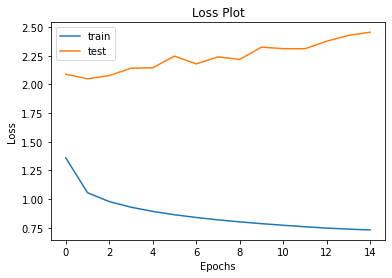

In [75]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend(['train', 'test'])
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

In [62]:
max_length = 10
attention_features_shape = next(iter(test_dataset))[0].shape[1]

### Greedy Search

In [63]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    # hidden = decoder.reset_state(batch_size=1)
    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_and_preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions, axis=1).numpy()[0] #extract the predicted id(embedded value) which carries the max value
        predicted_word = tokenizer.index_word[predicted_id] #map the id to the word from tokenizer
        result.append(predicted_word) #append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions


In [65]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    
    # plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [66]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [67]:
def generate_caption(test_image, evaluation_type='greedy', bleu_weights=(0.5, 0.5, 0, 0)):

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    if evaluation_type == 'greedy':
        result, attention_plot, pred_test = evaluate(test_image)
    elif evaluation_type == 'beam':
        result, attention_plot, pred_test = beam_evaluate(test_image, beam_index=3)

    real_caption = filt_text(real_caption)      

    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=bleu_weights)
    print(f"BLEU score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attmap(result, attention_plot, test_image)

    Image.open(test_image)
    
    return pred_caption

In [68]:
def generate_audio(pred_caption, audio_file, autoplay=False):
    #Google TTS
    speech = gTTS("Predicted Caption is: "+ pred_caption, lang='en', slow=False) 
    speech.save(audio_file)
    display.display(display.Audio(audio_file, rate=None,autoplay=autoplay))

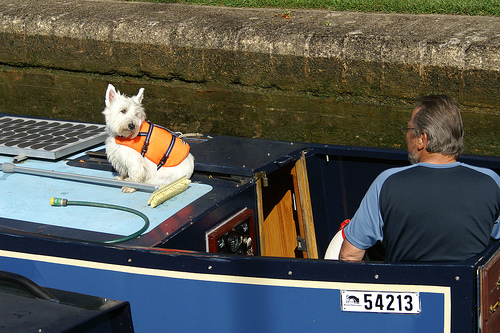

In [72]:
rid = np.random.randint(0, len(img_path_test))
test_image = img_path_test[rid]
audio_file = '../data/output/caption_audio.mp3'
Image.open(test_image)

/home/paresh/.cache/pypoetry/virtualenvs/upgrad-masters-ml-ai-7jz2oC-U-py3.8/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU score: 29.08342346129199
Real Caption: a dog in a life jacket sitting on a boat with a man in the cockpit
Prediction Caption: a man in a canoe with a dog


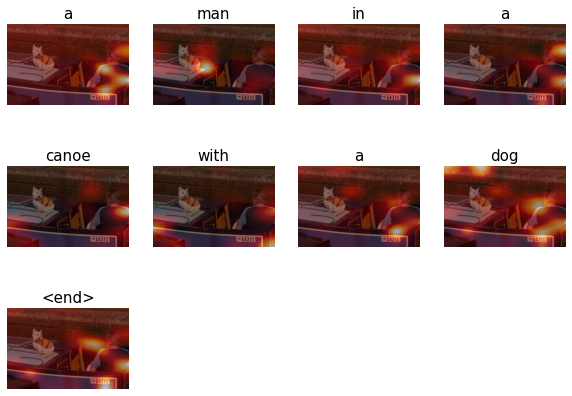

In [80]:
pred_caption = generate_caption(test_image, 'greedy', bleu_weights=(0.5, 0.5, 0, 0))
generate_audio(pred_caption, audio_file)